## Plot remote replay composition by day

In [11]:
import os
import pickle
import spyglass as nd
import pandas as pd
import statsmodels.api as sm
# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import logging
import multiprocessing

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

from spyglass.common import (Session, IntervalList,IntervalPositionInfo,
                             LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common.common_interval import _intersection

from spyglass.common.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, IntervalPositionInfoSelection


# Here are the analysis tables specific to Shijie Gu
from spyglass.Analysis_SGU import (TrialChoice,
                                   TrialChoiceReplay,
                                   RippleTimes,
                                   Decode,get_linearization_map,
                                   find_ripple_times,classify_ripples,classify_ripple_content,
                                   get_df_tally,find_tally_df)

In [91]:
nwb_file_names=['molly20220415.nwb','molly20220416.nwb','molly20220417.nwb','molly20220418.nwb','molly20220419.nwb','molly20220420.nwb']

In [92]:
H=[]
H_boot_mean=[]
H_boot_CI_l=[]
H_boot_CI_u=[]

O=[]
O_boot_mean=[]
O_boot_CI_l=[]
O_boot_CI_u=[]

for nwb_file_name in nwb_file_names:
    nwb_copy_file_name=get_nwb_copy_filename(nwb_file_name)
    decoding_path=(Decode &
               {'nwb_file_name': nwb_copy_file_name}).fetch('posterior')[0]
    animal=nwb_file_name[:5]
    date=nwb_copy_file_name[5:-5]
    resultfolder=os.path.join(os.path.split(decoding_path)[0],'analysis')
    
    data=pickle.load(open(os.path.join(resultfolder,
                              'replay_category_'+animal+'_'+date+'_remote.p'),"rb"))
    
    H.append(data['categories_H_day_prop'])
    H_boot_mean.append(data['H_boot_mean'])
    H_boot_CI_l.append(data['H_boot_CI'][0])
    H_boot_CI_u.append(data['H_boot_CI'][1])
    
    O.append(data['categories_O_day_prop'])
    O_boot_mean.append(data['O_boot_mean'])
    O_boot_CI_l.append(data['O_boot_CI'][0])
    O_boot_CI_u.append(data['O_boot_CI'][1])
H_boot_mean=np.array(H_boot_mean)
H_boot_CI_l=np.array(H_boot_CI_l)
H_boot_CI_u=np.array(H_boot_CI_u)

O_boot_mean=np.array(O_boot_mean)
O_boot_CI_l=np.array(O_boot_CI_l)
O_boot_CI_u=np.array(O_boot_CI_u)

In [93]:
np.array(H_boot_mean)

array([[0.        , 0.32963171, 0.32752421, 0.34284407],
       [0.        , 0.36135377, 0.29801801, 0.34062822],
       [0.        , 0.34905218, 0.31684557, 0.33410225],
       [0.        , 0.29094768, 0.37973897, 0.32931335],
       [0.        , 0.29200578, 0.37546946, 0.33252476],
       [0.        , 0.32735426, 0.33580519, 0.33684055]])

In [94]:
category_names_O=list(H[0].keys())
c=1
[H[d][category_names_O[c]] for d in range(len(H))]

[0.057971014492753624,
 0.14814814814814814,
 0.04225352112676056,
 0.05747126436781609,
 0.07608695652173914,
 0.07608695652173914]

In [95]:
category_names_H

['home', 'past', 'past_reward', 'future']

Text(1.5, 3.05, 'Replays at HOME')

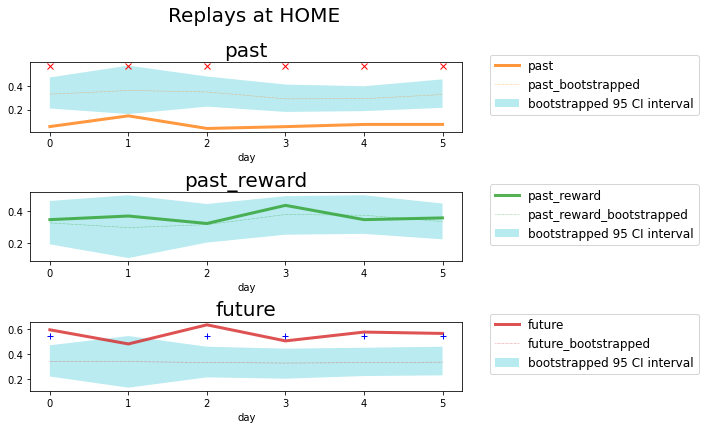

In [109]:
category_names_H=list(H[0].keys())
#category_names_H.remove('home')

fig,axes=plt.subplots(len(category_names_H)-1,1,figsize=(12, 12))

# plot result
ax_c=0
for c in range(len(category_names_H)):
    if c==0:
        continue
    data_result=[H[d][category_names_H[c]] for d in range(len(H))]
    axes[ax_c].plot(data_result,linewidth=3,color='C'+str(c),label=category_names_H[c],alpha=0.8)
    axes[ax_c].plot(H_boot_mean[:,c],linewidth=0.5,color='C'+str(c),label=category_names_H[c]+'_bootstrapped',linestyle=':')
    axes[ax_c].fill_between(np.arange(len(H)),
                         H_boot_CI_u[:,c],H_boot_CI_l[:,c],facecolor='C9', alpha=0.3,label='bootstrapped 95 CI interval')
    significant_ind_more=np.argwhere(data_result>(H_boot_CI_u[:,c]))
    significant_ind_less=np.argwhere(data_result<(H_boot_CI_l[:,c]))
    axes[ax_c].plot(significant_ind_more,np.ones_like(significant_ind_more)*np.max(H_boot_CI_u[:,c]),'+',color='b')
    axes[ax_c].plot(significant_ind_less,np.ones_like(significant_ind_less)*np.max(H_boot_CI_u[:,c]),'x',color='r')
        
    axes[ax_c].set_position([0.06,1-(c+1)*0.15-0.05,0.5,0.08])
    axes[ax_c].legend(fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axes[ax_c].set_xticks(np.arange(len(H)));
    axes[ax_c].set_xlabel('day');
    #axes[0].set_xticklabels(['1],fontsize=16);
    axes[ax_c].set_title(category_names_H[c],fontsize=20)
    ax_c=ax_c+1
plt.text(1.5,3.05,'Replays at HOME',fontsize=20)  

#plt.savefig(os.path.join(figurefolder,'C_Markovianess_'+animal+'.png'),bbox_inches='tight',dpi=500)
    

Text(1.5, 4.8, 'Replays at ARMs')

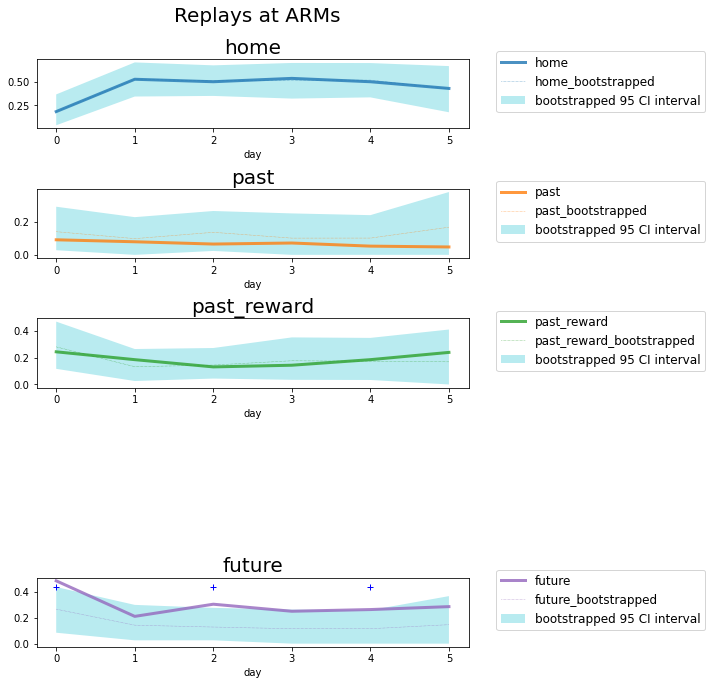

In [108]:
category_names_O=list(O[0].keys())
current_ind=np.argwhere([cat=='current' for cat in category_names_O]).ravel()[0]
fig,axes=plt.subplots(len(category_names_O)-1,1,figsize=(12, 12))

# plot result
ax_c=0
for c in range(len(category_names_O)):
    if c==current_ind:
        continue
    data_result=[O[d][category_names_O[c]] for d in range(len(H))]
    axes[ax_c].plot(data_result,linewidth=3,color='C'+str(c),label=category_names_O[c],alpha=0.8)
    axes[ax_c].plot(O_boot_mean[:,c],linewidth=0.5,color='C'+str(c),label=category_names_O[c]+'_bootstrapped',linestyle=':')
    axes[ax_c].fill_between(np.arange(len(O)),
                         O_boot_CI_u[:,c],O_boot_CI_l[:,c],facecolor='C9', alpha=0.3,label='bootstrapped 95 CI interval')
    significant_ind_more=np.argwhere(data_result>(O_boot_CI_u[:,c]))
    significant_ind_less=np.argwhere(data_result<(O_boot_CI_l[:,c]))
    axes[ax_c].plot(significant_ind_more,np.ones_like(significant_ind_more)*np.max(O_boot_CI_u[:,c]),'+',color='b')
    axes[ax_c].plot(significant_ind_less,np.ones_like(significant_ind_less)*np.max(O_boot_CI_u[:,c]),'x',color='r')
        
    axes[ax_c].set_position([0.06,1-(c+1)*0.15-0.05,0.5,0.08])
    axes[ax_c].legend(fontsize=12,bbox_to_anchor=(1.05, 1.2))
    
    axes[ax_c].set_xticks(np.arange(len(H)));
    axes[ax_c].set_xlabel('day');
    axes[ax_c].set_title(category_names_O[c],fontsize=20)
    ax_c=ax_c+1
    
plt.text(1.5,4.8,'Replays at ARMs',fontsize=20)    
#plt.savefig(os.path.join(figurefolder,'C_Markovianess_'+animal+'.png'),bbox_inches='tight',dpi=500)
    